# Part 1 : Preparing data to build RNN

### Import essential libraries needed

##### # Why Install `tf_keras` and `tensorflow` for Building RNNs?

- `tensorflow` is an open-source machine learning library developed by Google. It provides a comprehensive framework for building and deploying machine learning models, including deep learning architectures like RNNs.

- `tf_keras` is a high-level API within TensorFlow that simplifies the process of building neural networks. It is based on the Keras library, which provides an intuitive interface for creating and training deep learning models.

In [ ]:
#Installing packages
!pip install datasets
!pip install gensim
!pip install nltk
!pip install tf_keras
!pip install tensorflow
!pip install ktrain

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import numpy as np
from datasets import load_dataset
from matplotlib import pyplot as plt 

import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Attention, Input, GlobalAveragePooling1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import reduce_sum

In [3]:
import os
os.environ["TF_USE_LEGACY_KERAS"]="1"

### Load in dataset from question 1

In [3]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train'] 
validation_dataset = dataset['validation']
test_dataset = dataset['test']

##### 1. `preprocess(dataset)`

- The `preprocess` function is designed to preprocess text data in the input dataset, it performs tokenization, lowercasing, and punctuation removal on each sentence. 
- Since we will be preprocessing the three datasets (test, validation and training), we will create a function for easier accessibility.


##### 2. `find_max_sentence_length(dataset)`

- The `find_max_sentence_length` function calculates the maximum sentence length in the dataset after preprocessing.

##### 3. `label(dataset)`

- The `label` function extracts the labels from the dataset, converting them into a NumPy array for easier manipulation and model training.

In [5]:
def preprocess(dataset):
    
    processed_sentences = []

    for text in dataset['text']:
        # Preprocess the sentence (tokenisation, lowercasing, removing punctuation)
        processed_sentence = simple_preprocess(text)

        # Append the processed sentence to the list
        processed_sentences.append(processed_sentence)

    return processed_sentences

def find_max_sentence_length(dataset):
    max_sentence_length = 0

    for text in dataset['text']:
        # Preprocess the sentence (tokenisation, lowercasing, removing punctuation)
        processed_sentence = simple_preprocess(text)

        # Calculate the longest sentence length for later use
        if (len(processed_sentence) > max_sentence_length):
                max_sentence_length = len(processed_sentence)

    return max_sentence_length

def label(dataset):
    labels = dataset['label']
    labels = np.array(labels)
    return labels

In [6]:
processed_train = preprocess(train_dataset)
processed_val = preprocess(validation_dataset)
processed_test = preprocess(test_dataset)

max_sentence_length = find_max_sentence_length(train_dataset)

print("Max sentence length:", max_sentence_length)

Max sentence length: 50


In [7]:
train_labels = label(train_dataset)
val_labels = label(validation_dataset)
test_labels = label(test_dataset)

##### Tokenizer Initialization

- The `Tokenizer` class from Keras is initialized with a vocabulary limit of 10,000 words. 
- The `fit_on_texts` method is then called with the preprocessed training data (`processed_train`), assigning an index to each word in the vocabulary based on its frequency in the dataset. 
- This process prepares the text data for subsequent steps in model training.


In [8]:
#Initialise tokenizer
tokenizer = Tokenizer(num_words=10000)
# Assigns each word in the vocabulary to an index
tokenizer.fit_on_texts(processed_train)

##### Text to Sequences and Padding

- The `texts_to_sequences` method converts each sentence in `processed_train` into a sequence of integers, where each integer represents a word's index, with `0` reserved for padding. 
- The `pad_sequences` function then pads these sequences to a uniform length defined by `max_sentence_length`, ensuring that all input sequences have the same dimension for model training by adding zeros at the end (post-padding) or truncating longer sequences (post-truncating).


In [9]:
# Sets each word in a sentence to its index, 0 being reserved for padding
train_sequences = tokenizer.texts_to_sequences(processed_train)

# Pad sentences to max_sentence_length, which will be the dimension of our trained weights
train_padded = pad_sequences(train_sequences, maxlen=max_sentence_length, padding='post', truncating='post')

##### Repeating the process for both the validation and test datasets

In [10]:
val_sequences = tokenizer.texts_to_sequences(processed_val)
val_padded = pad_sequences(val_sequences, maxlen=max_sentence_length, padding='post', truncating='post')


In [11]:
test_sequences = tokenizer.texts_to_sequences(processed_test)
test_padded = pad_sequences(test_sequences, maxlen=max_sentence_length, padding='post', truncating='post')

##### Use the same word embedding model from question 1 to generate the embedding matrix

In [12]:
from gensim.models import KeyedVectors

glove_wiki_300 = KeyedVectors.load('./glove_wiki_gigaword_300.model')

print("Models loaded from local files.")

Models loaded from local files.


In [13]:
# Iterate over the list of processed sentences and get unique words
train_vocab = set(word for sentence in processed_train for word in sentence)

# (1a) Vocabulary size
vocab_size = len(train_vocab)
print("Size of vocabulary in training data:", vocab_size)

Size of vocabulary in training data: 16288


##### Vocabulary Size Adjustment

- The `+1` is added to `len(train_vocab)` to account for the reserved index `0`, which is used for padding in the embedding matrix. 
- This ensures that the matrix has the correct shape to include all words in the vocabulary, plus the additional index for padding. 
- By doing this, we prevent indexing errors when dealing with the padded sequences during model training.


In [14]:
# Define the embedding dimension
embedding_dim = glove_wiki_300.vector_size

# Get the size of the vocabulary. Index 0 is reserved for padding
train_vocab_size = len(train_vocab) + 1  # Make sure train_vocab is a set or list

# Initialize the embedding matrix
embedding_matrix = np.zeros((train_vocab_size, embedding_dim))

# Populate the embedding matrix
for word, idx in tokenizer.word_index.items():
    if word in glove_wiki_300:
        embedding_matrix[idx] = glove_wiki_300[word]
    else:
        # Use zero vector for OOV words
        embedding_matrix[idx] = np.zeros(embedding_dim)


In [15]:
# Print the shape of the embedding matrix
print("Shape of the embedding matrix:", embedding_matrix.shape)

# Print the first 5 embeddings
print("First 5 embeddings:")
print(embedding_matrix[:5])  # Adjust the slice as needed

Shape of the embedding matrix: (16289, 300)
First 5 embeddings:
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.04656     0.21318001 -0.0074364  ...  0.0090611  -0.20988999
   0.053913  ]
 [ 0.038466   -0.039792    0.082747   ... -0.33427     0.011807
   0.059703  ]
 [-0.076947   -0.021211    0.21270999 ...  0.18351001 -0.29183
  -0.046533  ]
 [-0.25756001 -0.057132   -0.67189997 ... -0.16043     0.046744
  -0.070621  ]]


# Part 2. Model Training & Evaluation - RNN

##### Learning Rate Finder and Plot

- The `learner.lr_find()` method is used to identify an optimal learning rate for the model by testing a range of values and observing the loss. 
- Following this, `learner.lr_plot(suggest=True)` generates a plot of the learning rates versus the corresponding losses, highlighting the suggested optimal learning rate. 
- This approach helps in selecting an appropriate learning rate that can improve model convergence during training.


In [21]:
learner = ktrain.get_learner(model, train_data=(train_padded, train_labels), batch_size=32)

c:\Users\taich\AppData\Local\Programs\Python\Python311\Lib\site-packages\ktrain\__init__.py:138: UserWarning: ktrain currently only supports legacy optimizers in tensorflow>=2.11 - recompiling your model to use legacy Adam
  warnings.warn(


In [22]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...


c:\Users\taich\AppData\Local\Programs\Python\Python311\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/1024
267/267 [==============================] - 4s 12ms/step - loss: 0.7325 - accuracy: 0.4973
Epoch 2/1024
267/267 [==============================] - 3s 12ms/step - loss: 0.7240 - accuracy: 0.5073
Epoch 3/1024
267/267 [==============================] - 3s 12ms/step - loss: 0.6596 - accuracy: 0.6023
Epoch 4/1024
267/267 [==============================] - 3s 12ms/step - loss: 0.6003 - accuracy: 0.6886
Epoch 5/1024
267/267 [==============================] - 3s 12ms/step - loss: 0.8672 - accuracy: 0.5436
Epoch 6/1024
267/267 [==============================] - 1s 5ms/step - loss: 3.3048 - accuracy: 0.5121


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 9.31E-05
	Min numerical gradient (purple): 2.13E-04
	Min loss divided by 10 (omitted from plot): 1.12E-04


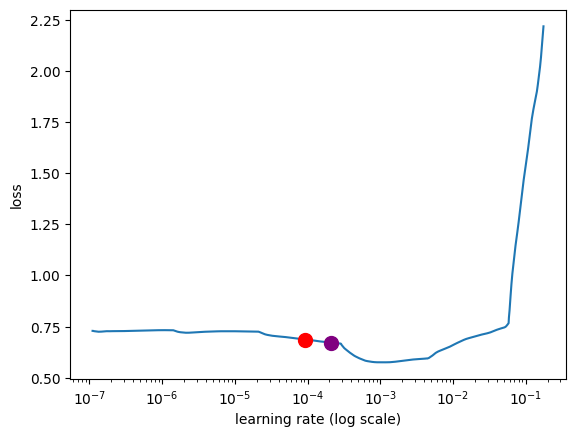

In [23]:
learner.lr_plot(suggest=True)

With this data, we choose preliminarily to use a static learning rate of 2e-4

##### Model Training

- The `use_model` function defines a simple sequential Keras model for binary classification using an RNN architecture. 
- It begins by creating an embedding layer initialized with pre-trained embeddings from question 1, followed by a `SimpleRNN` layer with a specified number of hidden neurons and a dense output layer with a sigmoid activation for binary predictions. 
- The model is compiled with binary cross-entropy loss and the Adam optimizer, and it incorporates early stopping based on validation loss during training. After fitting the model, it visualizes the training and validation accuracy and loss over epochs using Matplotlib.


In [16]:
def use_model(hidden_neurons, learning_rate, batch_size, epochs):

    # simple sequential Keras model
    model = Sequential()

    embedding_layer = Embedding(input_dim=train_vocab_size, 
                        output_dim=embedding_dim, 
                        mask_zero=True, 
                        trainable=False)

    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    model.add(embedding_layer)
    model.add(SimpleRNN(units=hidden_neurons))
    model.add(Dense(1, activation='sigmoid'))

    print(model.summary())
    
    # Compile the model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['accuracy'])
    
    # early stopping criteria when the valdiation loss starts increasing
    stopping_criteria = EarlyStopping(
    monitor='val_loss',
    patience=4, 
    verbose=1,
    restore_best_weights=True
    )

    #fit the model
    history = model.fit(train_padded, 
                        train_labels,
                        batch_size=batch_size, 
                        epochs=epochs, 
                        callbacks=(stopping_criteria),
                        validation_data=(val_padded, val_labels))
    
    # plotting the training accuracy and the validation accuracy from the model against number of epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # plotting the training loss and the validation loss from the model against number of epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    return model
    

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (1, 300)               │     4,886,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,886,700 (18.64 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,886,700 (18.64 MB)

None
Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4904 - loss: 0.7406 - val_accuracy: 0.5197 - val_loss: 0.7126
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5301 - loss: 0.7024 - val_accuracy: 0.5478 - val_loss: 0.6920
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5719 - loss: 0.6780 - val_accuracy: 0.5826 - val_loss: 0.6712
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6249 - loss: 0.6451 - val_accuracy: 0.6595 - val_loss: 0.6265
Epoch 5/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6832 - loss: 0.5927 - val_accuracy: 0.6961 - val_loss: 0.5866
Epoch 6/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7084 - loss: 0.5708 - val_accuracy: 0.7139 - val_loss: 0.5691
Epoch 7/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7390 - loss: 0.5345 - val_accuracy: 0.7139 - val_loss: 0.5576
Epoch 8/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7433 - loss: 0.5290 - val_accurac

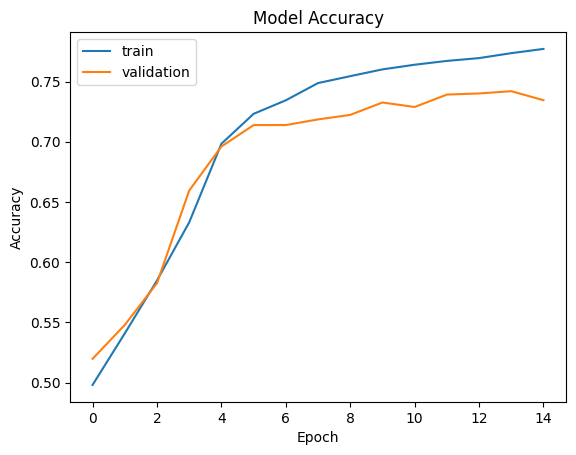

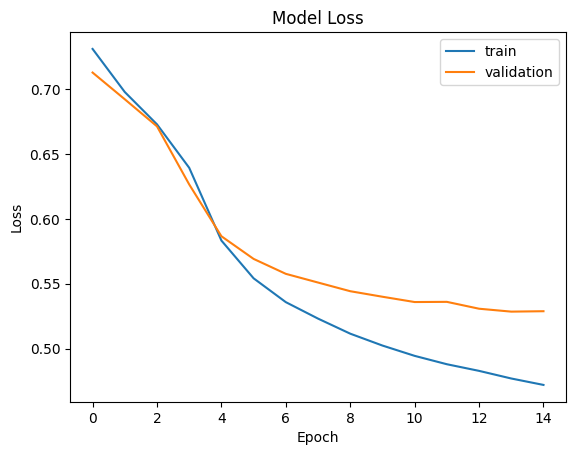


Test loss and accuracy is:
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7345 - loss: 0.5234


In [ ]:
results = use_model(hidden_neurons=60, learning_rate=2e-4, batch_size=32, epochs=15)
# Also tested with hidden_neurons=60, learning_rate=0.00005, batch_size=30, epochs=15, seems slightly better can try again

# Run on test data
print('\nTest loss and accuracy is:')
scores = results.evaluate(x=test_padded, y=test_labels)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (1, 300)               │     4,886,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,886,700 (18.64 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,886,700 (18.64 MB)

None
Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5304 - loss: 0.7053 - val_accuracy: 0.6904 - val_loss: 0.5886
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7154 - loss: 0.5530 - val_accuracy: 0.7158 - val_loss: 0.5626
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7565 - loss: 0.5035 - val_accuracy: 0.7251 - val_loss: 0.5333
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7702 - loss: 0.4863 - val_accuracy: 0.7345 - val_loss: 0.5259
Epoch 5/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7797 - loss: 0.4717 - val_accuracy: 0.7364 - val_loss: 0.5230
Epoch 6/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7787 - loss: 0.4664 - val_accuracy: 0.7420 - val_loss: 0.5218
Epoch 7/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7937 - loss: 0.4441 - val_accuracy: 0.7317 - val_loss: 0.5263
Epoch 8/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7929 - loss: 0.4377 - val_accurac

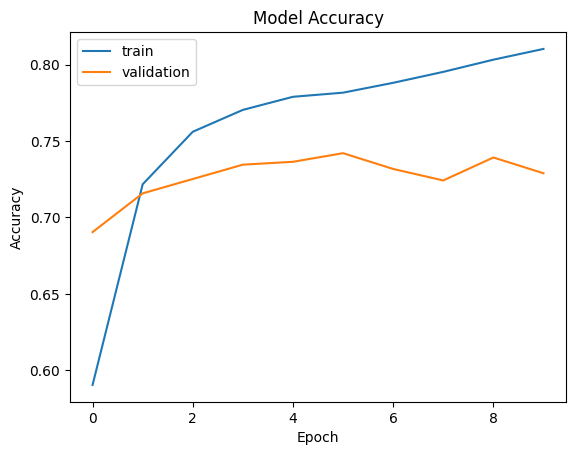

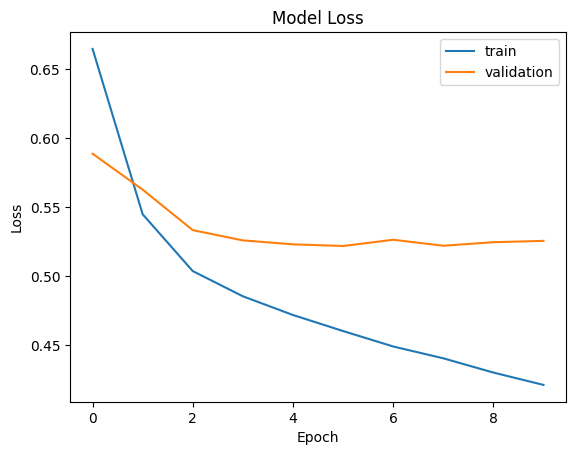


Test loss and accuracy is:
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7345 - loss: 0.5234


In [21]:
# Define exponential decay schedule
initial_learning_rate = 2.13e-4
decay_steps = len(train_padded) // 16
decay_rate = 0.96
learning_rate_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

use_model(hidden_neurons=60, learning_rate=learning_rate_schedule, batch_size=30, epochs=15)

# Run on test data
print('\nTest loss and accuracy is:')
scores = results.evaluate(x=test_padded, y=test_labels)

## Attention Mechanism

In [ ]:
def use_model_with_attention(hidden_neurons, learning_rate, batch_size, epochs, max_length):
    # Input layer
    input_seq = Input(shape=(max_length,))

     # Embedding layer
    embedding_layer = Embedding(input_dim=train_vocab_size, 
                                output_dim=embedding_dim, 
                                mask_zero=True, 
                                trainable=False
                            )(input_seq)
    
    # RNN layer with attention mechanism
    rnn_output = SimpleRNN(units=hidden_neurons, return_sequences=True)(embedding_layer)

    # Attention layer
    attention_output = Attention()([rnn_output, rnn_output])
    attention_output = reduce_sum(attention_output, axis=1)

     # Output layer
    output = Dense(1, activation='sigmoid')(attention_output)

    model = Model(inputs=input_seq, outputs=output)
    print(model.summary())

    # Compile the model
    model.compile(
        loss='binary_crossentropy', 
        optimizer=Adam(learning_rate=learning_rate), 
        metrics=['accuracy']
    )

    # early stopping criteria when the valdiation loss starts increasing
    stopping_criteria = EarlyStopping(
        monitor='val_loss',
        patience=4, 
        verbose=1,
        restore_best_weights=True
    )

    # Fit the model
    history = model.fit(
        train_padded, 
        train_labels,
        batch_size=batch_size, 
        epochs=epochs, 
        callbacks=[stopping_criteria],
        validation_data=(val_padded, val_labels)
    )

    # Plot accuracy and loss
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    return model


In [31]:
attention_model = use_model_with_attention(hidden_neurons=60, learning_rate=0.00005, batch_size=30, epochs=15, max_length=50)
print('\nTest loss and accuracy is:')
scores = attention_model.evaluate(x=test_padded, y=test_labels)

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


## Mean Pooling

In [36]:
def use_model_with_mean_pooling(hidden_neurons, learning_rate, batch_size, epochs, input_length):
    
    model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=50),
    SimpleRNN(hidden_neurons, return_sequences=True),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
    ])

    print(model.summary())
    
    # Compile the model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['accuracy'])
    
    # Early stopping criteria
    stopping_criteria = EarlyStopping(
        monitor='val_loss',
        patience=4, 
        verbose=1,
        restore_best_weights=True
    )

    # Fit the model
    history = model.fit(train_padded, 
                        train_labels,
                        batch_size=batch_size, 
                        epochs=epochs, 
                        callbacks=[stopping_criteria],
                        validation_data=(val_padded, val_labels))
    
    # Plotting the training accuracy and validation accuracy against the number of epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # Plotting the training loss and validation loss against the number of epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    return model

c:\Users\john1\Desktop\SC4002-NLP-G14\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.5566 - loss: 0.6803 - val_accuracy: 0.6689 - val_loss: 0.6138
Epoch 2/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.7534 - loss: 0.5260 - val_accuracy: 0.7214 - val_loss: 0.6086
Epoch 3/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.8437 - loss: 0.3843 - val_accuracy: 0.7261 - val_loss: 0.5607
Epoch 4/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.8989 - loss: 0.2766 - val_accuracy: 0.7364 - val_loss: 0.6160
Epoch 5/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.9312 - loss: 0.2089 - val_accuracy: 0.7186 - val_loss: 0.7470
Epoch 6/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.9324 - loss: 0.2051 - val_accuracy: 0.7205 - val_loss: 0.6401
Epoch 7/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9531 - loss: 0.1415 - val_accuracy: 0.7148 - val_loss: 0.8088
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 3.


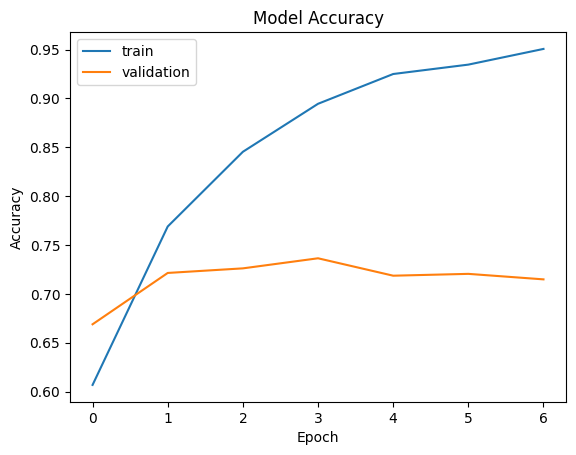

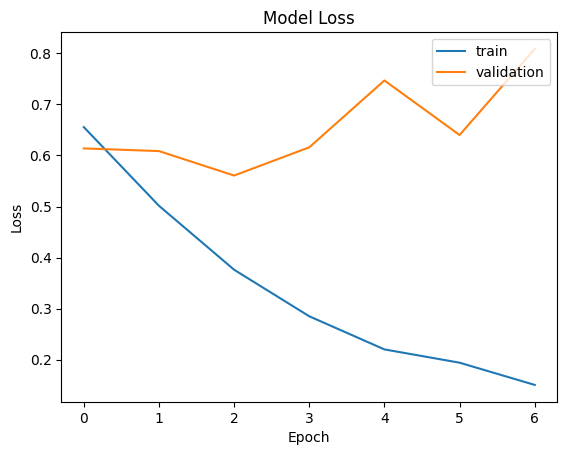


Test loss and accuracy is:
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7418 - loss: 0.5433


In [38]:
mean_pooling_model = use_model_with_mean_pooling(hidden_neurons=300, learning_rate=0.00005, batch_size=16, epochs=15, input_length=50)

print('\nTest loss and accuracy is:')
scores = mean_pooling_model.evaluate(x=test_padded, y=test_labels)

## Max Pooling

In [ ]:
def use_model_with_max_pooling(hidden_neurons, learning_rate, batch_size, epochs, input_length):
    
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
        SimpleRNN(300, return_sequences=True),
        GlobalMaxPooling1D(),
        Dense(1, activation='sigmoid')
    ])

    print(model.summary())
    
    # Compile the model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['accuracy'])
    
    # Early stopping criteria
    stopping_criteria = EarlyStopping(
        monitor='val_loss',
        patience=4, 
        verbose=1,
        restore_best_weights=True
    )

    # Fit the model
    history = model.fit(train_padded, 
                        train_labels,
                        batch_size=batch_size, 
                        epochs=epochs, 
                        callbacks=[stopping_criteria],
                        validation_data=(val_padded, val_labels))
    
    # Plotting the training accuracy and validation accuracy against the number of epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # Plotting the training loss and validation loss against the number of epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    return model

c:\Users\john1\Desktop\SC4002-NLP-G14\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.5245 - loss: 0.6921 - val_accuracy: 0.5994 - val_loss: 0.6608
Epoch 2/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.6818 - loss: 0.5990 - val_accuracy: 0.7186 - val_loss: 0.5559
Epoch 3/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.8268 - loss: 0.4084 - val_accuracy: 0.7383 - val_loss: 0.5665
Epoch 4/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.8969 - loss: 0.2759 - val_accuracy: 0.7345 - val_loss: 0.6090
Epoch 5/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.9297 - loss: 0.2025 - val_accuracy: 0.7439 - val_loss: 0.6369
Epoch 6/15
534/534 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.9574 - loss: 0.1424 - val_accuracy: 0.7205 - val_loss: 0.7444
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 2.


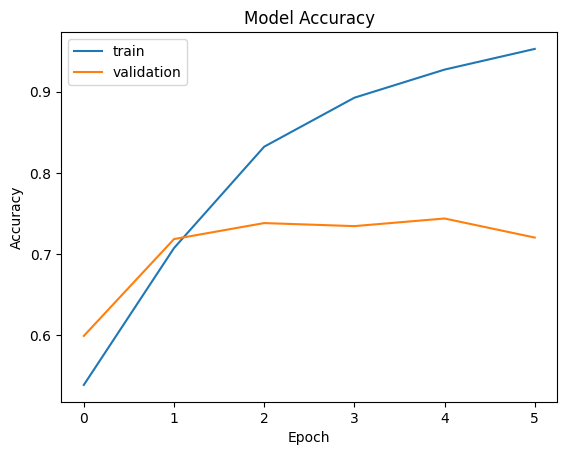

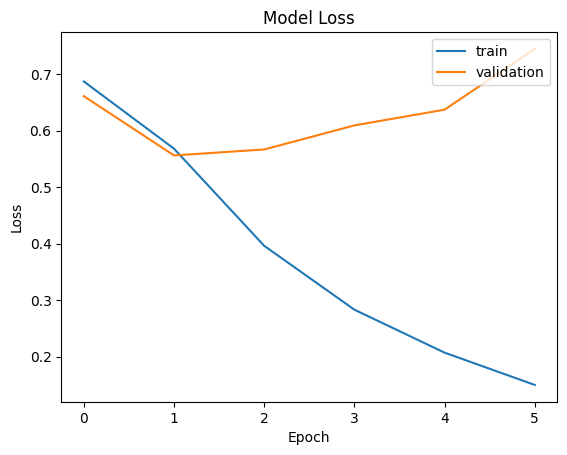


Test loss and accuracy is:
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6737 - loss: 0.5955


In [41]:
max_pooling_model = use_model_with_max_pooling(hidden_neurons=300, learning_rate=0.00005, batch_size=16, epochs=15, input_length=50)

print('\nTest loss and accuracy is:')
scores = max_pooling_model.evaluate(x=test_padded, y=test_labels)